In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.io import imread_collection
from ast import Yield
import matplotlib.pyplot as plt
import glob
import cv2
import os

In [2]:
train_dir = 'data/train/*.png'
val_dir = 'data/validation/*.png'
Y_train = np.loadtxt('data/train.csv', delimiter=',', skiprows=1, usecols=1)
Y_val = np.loadtxt('data/validation.csv', delimiter=',', skiprows=1, usecols=1)
#creating a collection with the available images
train = imread_collection(train_dir)
val = imread_collection(val_dir)

# X = [color.rgb2gray(image).ravel() for image in train]
X_train=[]
for image in train:
    grayscale_image = color.rgb2gray(image)
    flattened_image = grayscale_image.ravel()

    # Normalize pixel values to the range [0, 1]
    normalized_image = (flattened_image - flattened_image.min()) / (flattened_image.max() - flattened_image.min())

    X_train.append(normalized_image)
X_train = np.array(X_train)

In [3]:
X_train

array([[0.66953786, 0.66953786, 0.66953786, ..., 0.66953786, 0.66953786,
        0.66953786],
       [0.96056028, 0.96056028, 0.96056028, ..., 0.96056028, 0.96056028,
        0.96056028],
       [0.19609194, 0.19609194, 0.19609194, ..., 0.19609194, 0.19609194,
        0.19609194],
       ...,
       [0.80212401, 0.80212401, 0.80212401, ..., 0.80212401, 0.80212401,
        0.80212401],
       [0.46258988, 0.46258988, 0.46258988, ..., 0.46258988, 0.46258988,
        0.46258988],
       [0.88672081, 0.88672081, 0.88672081, ..., 0.88672081, 0.88672081,
        0.88672081]])

In [4]:
import cv2
from skimage.io import imread_collection
import numpy as np
import pandas as pd

# Update file paths using forward slashes or raw string
train_path = 'data/train/*.png'
val_path = 'data/validation/*.png'
y_path = 'data/train.csv'
y_val_path ='data/validation.csv'

# Read training images
X_train = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob(train_path)]

Y_train = pd.read_csv(y_path)

y_val = pd.read_csv(y_val_path)

# Read validation images using imread_collection
X_val = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in glob.glob(val_path)]

# If you want to convert the validation images to a numpy array
X_val_array = np.array(X_val)/255




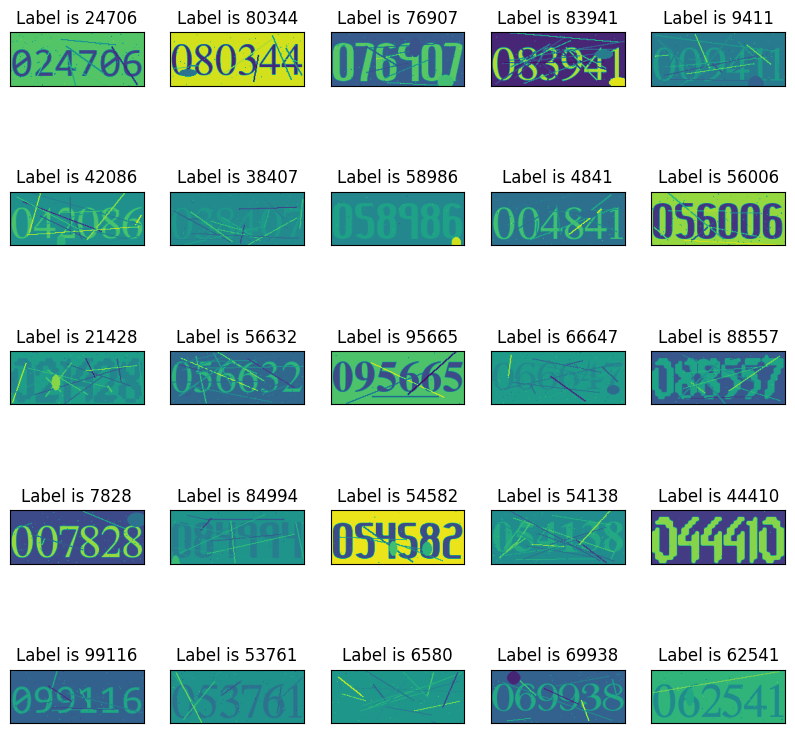

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    label = Y_train.iloc[i]['Label']
    plt.title(f'Label is {label}')


plt.show()

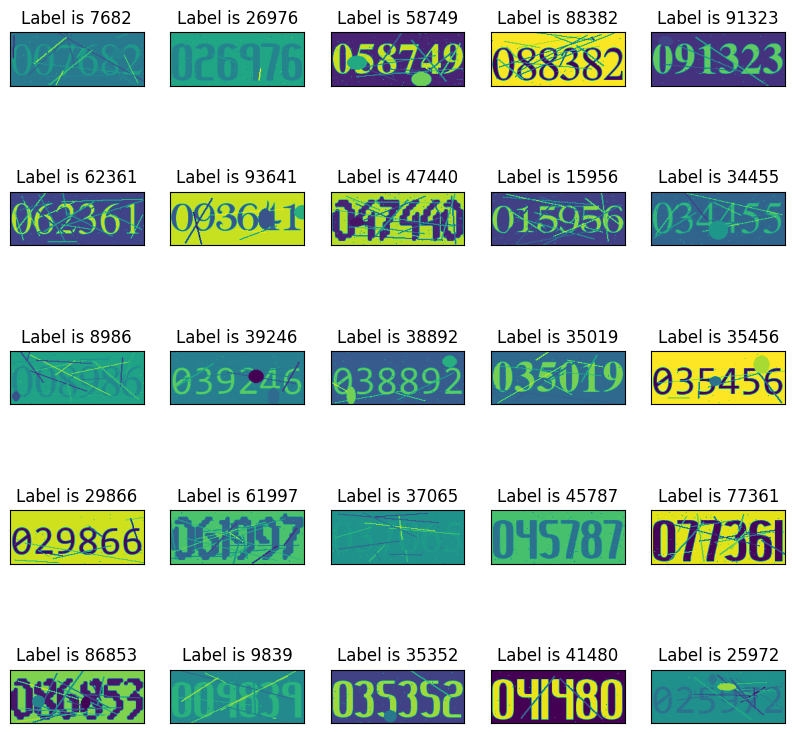

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_val[i])
    label = y_val.iloc[i]['Label']
    plt.title(f'Label is {label}')


plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Y_train_labels = Y_train['Label'].to_numpy()
y_combine = LabelEncoder().fit_transform(Y_train_labels)
y_one_hot = OneHotEncoder().fit_transform(y_combine.reshape(len(y_combine),1))

In [8]:
X_train= np.array(X_train)
print(X_train.shape)
print(y_one_hot.shape)

(100, 80, 200)
(100, 100)
